In [1]:
import pymultinest

In [2]:
import bilby
import jax
import jax.numpy as jnp
import pandas as pd
import scipy.stats as ss
import numpy as np

In [3]:
 bilby.core.utils.logger.setLevel("ERROR")

In [22]:
# A few simple setup steps
label = "JLA"
wCDM = True
if wCDM:
    outdir = "samples/JLA-wCDM"
else:
    outdir = "samples/JLA-LCDM"

## Data

In [5]:
data = pd.read_csv("data/jla_lcparams.txt", sep=" ", header=0)
covariance = np.load("data/covariance.npz")["arr_0"]
ndata = len(data)

columns = ["mb", "zcmb", "3rdvar", "x1", "color"]
data_filtered = data[columns]
data_filtered.columns = ["mb", "redshift", "M_stellar", "X_1", "C"]

inputs = data_filtered[["redshift", "M_stellar", "X_1", "C"]].values

## Functions

In [6]:
def compute_app_mag(redshift, m_stellar, x_1, color, cosmo_params, nuisance_params):
    """
    Compute the apparent magnitude based on cosmological parameters, redshift, and nuisance parameters.

    Parameters:
    -----------
    redshift : float
        The redshift of the object.
    m_stellar : float
        The stellar mass of the object.
    x_1 : float
        The stretch parameter for the supernova.
    color : float
        The color parameter for the supernova.
    cosmo_params : tuple
        A tuple containing the cosmological parameters:
        - omega_matter (float): The matter density parameter.
        - w_0 (float): The equation of state parameter for dark energy.
    nuisance_params : tuple
        A tuple containing the nuisance parameters:
        - m_b (float): The base magnitude.
        - delta_m (float): The change in magnitude for stellar mass > 10.
        - alpha (float): The stretch correction parameter.
        - beta (float): The color correction parameter.

    Returns:
    --------
    float
        The apparent magnitude computed from the cosmological and nuisance parameters.

    Notes:
    ------
    The function computes the apparent magnitude by first calculating the cosmological component,
    which is determined by integrating over a redshift grid using the trapezoidal rule. The nuisance
    component is then added, where the base magnitude may be adjusted by delta_m if the stellar mass
    is greater than 10. The stretch and color corrections are also applied to the nuisance component.
    """
    # unpack the parameters
    omega_matter, w_0 = cosmo_params
    m_b, delta_m, alpha, beta = nuisance_params

    # cosmological part
    factor = 10**5 * (1.0 + redshift) * 299792.458 / 70.0
    zgrid = jnp.linspace(0.0, redshift, 1000)
    fgrid = 1.0 / jnp.sqrt(
        omega_matter * (1 + zgrid) ** 3
        + (1 - omega_matter) * (1 + zgrid) ** (3 * (1 + w_0))
    )
    cosmology = 5.0 * jnp.log10(factor * jnp.trapezoid(fgrid, zgrid))

    # nuisance part
    def use_delta_m(m_b):
        return m_b + delta_m

    def skip_delta_m(m_b):
        return m_b

    nuisance = (
        jax.lax.cond(m_stellar > 10, use_delta_m, skip_delta_m, m_b)
        - alpha * x_1
        + beta * color
    )

    return cosmology + nuisance

In [23]:
class JLAGaussianLikelihood(bilby.Likelihood):
    def __init__(self, data, covariance):
        """
        A very simple Gaussian likelihood

        Parameters
        ----------
        data: array_like
            The data to analyse
        """
        if wCDM:
            parameters={"Omega_m": None, 
                        "w_0": None,
                        "abs_mag": None,
                        "delta_m": None, 
                        "alpha": None,
                        "beta": None}
        else:
            parameters={"Omega_m": None, 
                        "abs_mag": None,
                        "delta_m": None, 
                        "alpha": None,
                        "beta": None}        
        
        super().__init__(parameters)
        self.data = data
        self.covariance = covariance
        self.dist = ss.multivariate_normal(self.data, self.covariance)

    def log_likelihood(self):
        Omega_m = self.parameters["Omega_m"]
        abs_mag = self.parameters["abs_mag"]
        delta_m = self.parameters["delta_m"]
        alpha = self.parameters["alpha"]
        beta = self.parameters["beta"]
        if wCDM:
            w_0 = self.parameters["w_0"]
        else:
            w_0 = -1.0
        
        cosmo_params = (Omega_m, w_0)
        nuisance_params = (abs_mag, delta_m, alpha, beta)
        
        def compute_theory(inputs):
            redshift, m_stellar, x_1, color = inputs
            return compute_app_mag(redshift, m_stellar, x_1, color, cosmo_params, nuisance_params)
            
        theory = jax.lax.map(compute_theory, inputs)
        return self.dist.logpdf(np.asarray(theory))

## Priors

In [24]:
priors = dict(
    Omega_m = bilby.core.prior.Uniform(0.001, 0.6, "Omega_m"),
    abs_mag = bilby.core.prior.Normal(-19.0, 1.0, "abs_mag"),
    delta_m = bilby.core.prior.Normal(-0.05, 1.0, "delta_m"),
    alpha = bilby.core.prior.Normal(0.125, 1.0, "alpha"),
    beta = bilby.core.prior.Normal(2.6, 1.0, "beta"))


if wCDM:
    priors["w_0"] = bilby.core.prior.Uniform(-1.50, 0.0, "w_0")

## Likelihood

In [25]:
likelihood = JLAGaussianLikelihood(data_filtered['mb'].values, covariance)

## Run the Sampler

In [27]:
result = bilby.run_sampler(
    likelihood=likelihood,
    priors=priors,
    sampler="pymultinest",
    npoints=1000,
    outdir=outdir,
    label=label,
)

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points = 1000
 dimensionality =    6
 *****************************************************
 Starting MultiNest
 generating live points
 live points generated, starting sampling
Acceptance Rate:                        0.999049
Replacements:                               1050
Total Samples:                              1051
Nested Sampling ln(Z):             -62324.984385
Acceptance Rate:                        0.994575
Replacements:                               1100
Total Samples:                              1106
Nested Sampling ln(Z):             -45802.377223
Acceptance Rate:                        0.986278
Replacements:                               1150
Total Samples:                              1166
Nested Sampling ln(Z):             -37190.468293
Acceptance Rate:            

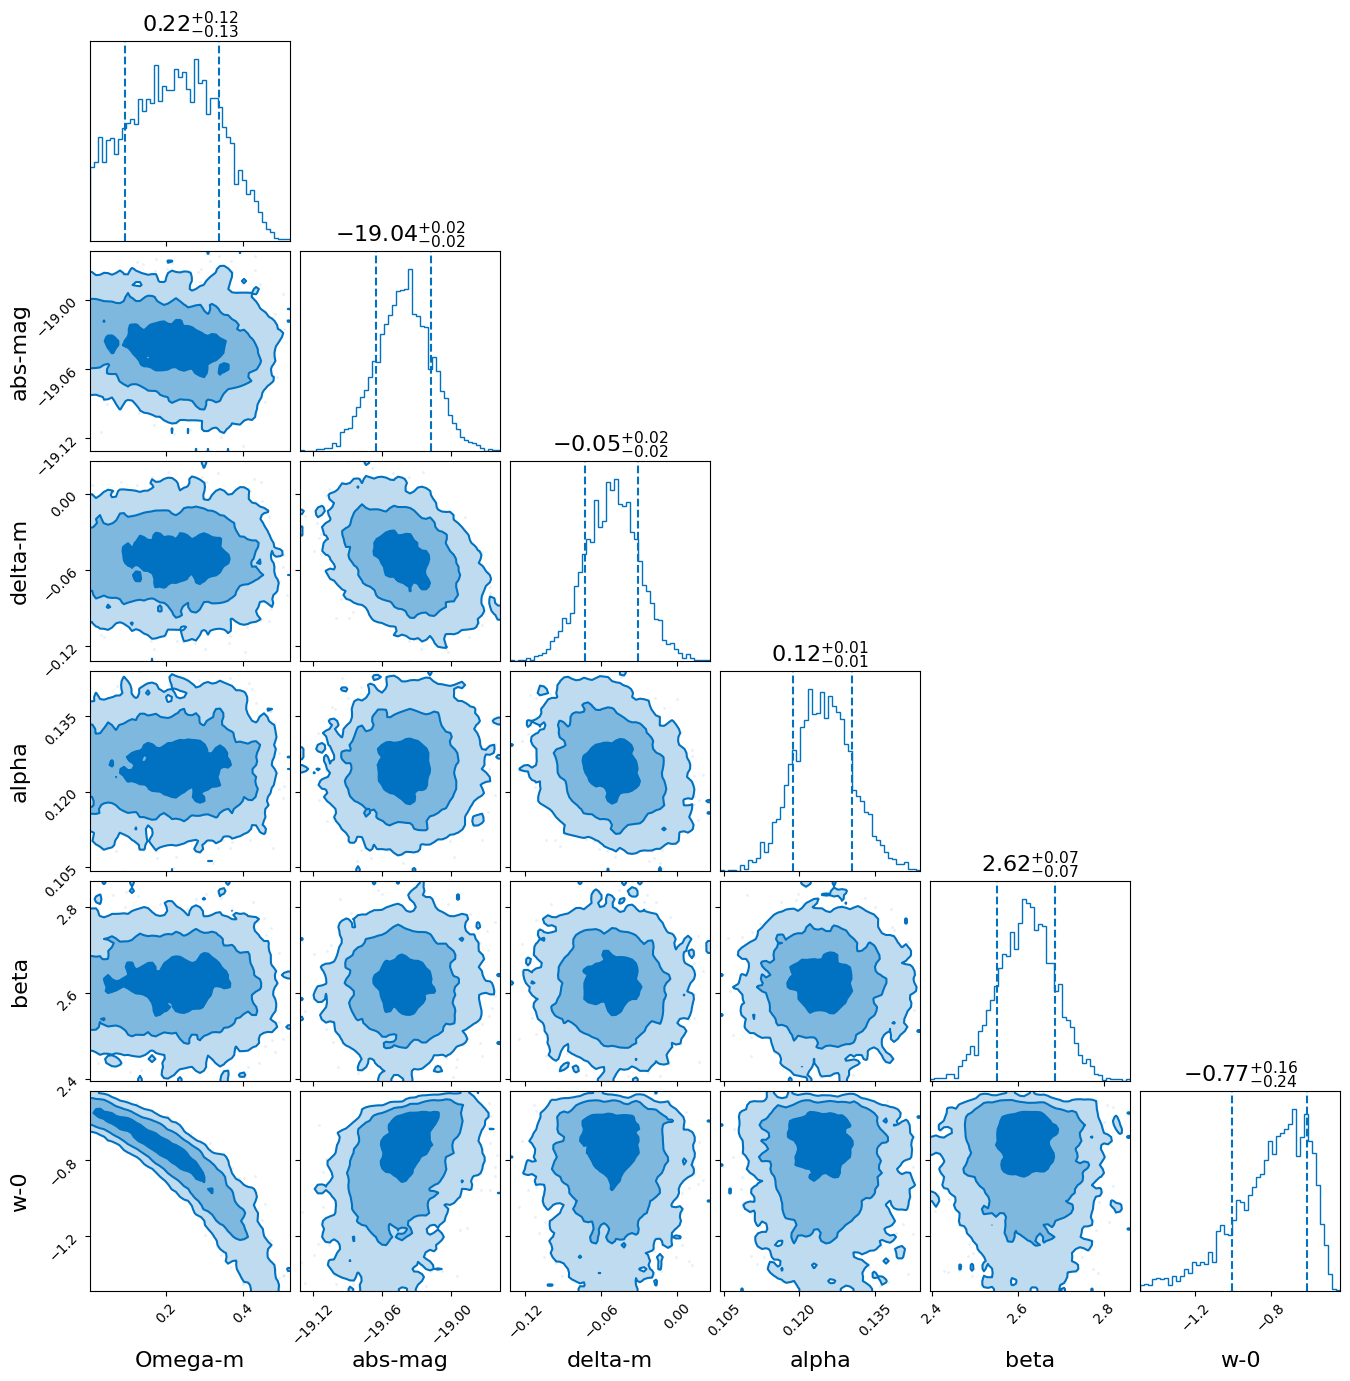

In [28]:
result.plot_corner()

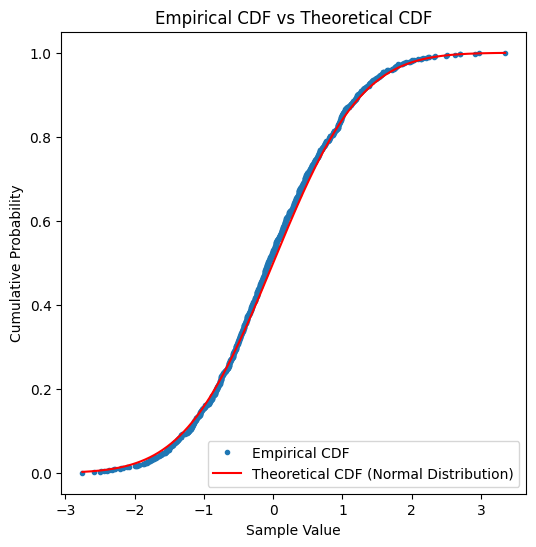

KS Statistic: 0.03315212222707775, P-value: 0.21688075267567153


In [32]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import kstest, norm

# Generate 1D sample data (for example, using normal distribution)
samples = np.random.normal(loc=0, scale=1, size=1000)  # Mean 0, Std dev 1, 100 samples

# Step 1: Compute the empirical CDF (ECDF)
def ecdf(data):
    """ Compute the empirical CDF of the given data. """
    n = len(data)
    x = np.sort(data)
    y = np.arange(1, n + 1) / n
    return x, y

# Step 2: Plot the empirical CDF (ECDF)
x, y = ecdf(samples)

# Step 3: Plot the theoretical CDF for comparison (e.g., standard normal distribution)
x_theory = np.linspace(min(samples), max(samples), 1000)
y_theory = norm.cdf(x_theory, loc=0, scale=1)  # Theoretical CDF of standard normal distribution

# Step 4: Plot the ECDF and theoretical CDF
plt.figure(figsize=(6, 6))
plt.plot(x, y, marker='.', linestyle='none', label='Empirical CDF')
plt.plot(x_theory, y_theory, label='Theoretical CDF (Normal Distribution)', color='red')
plt.xlabel('Sample Value')
plt.ylabel('Cumulative Probability')
plt.title('Empirical CDF vs Theoretical CDF')
plt.legend()
# plt.grid()
plt.show()

# Step 5: Perform the Kolmogorov-Smirnov test
ks_statistic, p_value = kstest(samples, 'norm', args=(0, 1))  # Test against a normal distribution with mean 0, std 1
print(f"KS Statistic: {ks_statistic}, P-value: {p_value}")